(50000, 28, 28) (50000,) (10000, 28, 28) (10000, 28, 28)


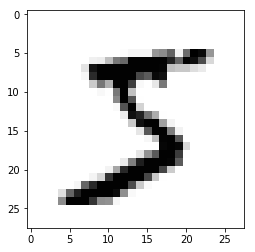

In [50]:

import tensorflow as tf
import numpy as np
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape,X_val.shape,X_test.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [51]:
#convert targets into one_hot
#print(set(y_train))
#print(y_train[0:5])
#y_train_onehot=tf.one_hot(y_train,depth=10,on_value=1,off_value=0)
#print(y_train_onehot[0])
#tf.reset_default_graph()

In [52]:
#define some global constants: neurons per hidden layer
L1=300
L2=150
L3=50

In [53]:
#placeholders input output 
X= tf.placeholder(tf.float32, [None, 28, 28])
y= tf.placeholder(tf.int64, [None]) 


In [54]:
#variables : weights and biases
W1 = tf.Variable(tf.truncated_normal([784, L1], stddev=0.1))                                                            
B1 = tf.Variable(tf.zeros([L1]))
W2 = tf.Variable(tf.truncated_normal([L1, L2], stddev=0.1))
B2 = tf.Variable(tf.zeros([L2]))
W3 = tf.Variable(tf.truncated_normal([L2, L3], stddev=0.1))
B3 = tf.Variable(tf.zeros([L3]))
W4 = tf.Variable(tf.truncated_normal([L3, 10], stddev=0.1))
B4 = tf.Variable(tf.zeros([10]))

In [55]:
#the  neural net
X_flat=tf.reshape(X, [-1, 784])
Y_hid_1 = tf.nn.sigmoid(tf.matmul(X_flat, W1) + B1)
Y_hid_1_dp = tf.nn.dropout(Y_hid_1, 0.7)
Y_hid_2 = tf.nn.sigmoid(tf.matmul(Y_hid_1_dp, W2) + B2)
Y_hid_2_dp = tf.nn.dropout(Y_hid_2, 0.8)
Y_hid_3 = tf.nn.sigmoid(tf.matmul(Y_hid_2, W3) + B3)
Y_hid_3_dp = tf.nn.dropout(Y_hid_3, 0.9)
y_logits=tf.matmul(Y_hid_3_dp, W4) + B4
y_pred = tf.nn.softmax(tf.matmul(Y_hid_3, W4) + B4)
y_true=tf.one_hot(y,depth=10,on_value=1,off_value=0)

In [56]:
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y), reduction_indices=[1]))
#can't use this while training :https://github.com/tensorflow/tensorflow/issues/2462

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_logits, labels=y_true))
learning_rate = 0.003 #no hyperoptimization, no use of validation data yet
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_pred, 1),y),dtype=tf.float32))

In [57]:
#finally inintialize tf 

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [58]:
def batch_generator(inp_array,batch_size=50):
    start_index=0
    exhausted=False
    while 1:
        if exhausted:return #raise StopIteration("Ran out of data, can't suppy more images to the model") deprecated since python3.5
        if start_index+batch_size>=len(inp_array):
            ret_array=inp_array[start_index:]
            exhausted=True
        else:
            ret_array=inp_array[start_index:start_index+batch_size]
            start_index+=batch_size
        yield ret_array


In [59]:

#now training and validation
n_epochs=100
batch_size=250
loss=None
acc=0
num_train=X_train.shape[0]

train_losses=[]
val_losses=[]
test_losses=[]
for epoch in range(n_epochs):
    shuffle_index=np.arange(num_train)
    np.random.shuffle(shuffle_index)
    X_train=X_train[shuffle_index]
    y_train=y_train[shuffle_index]
    my_X_generator=batch_generator(X_train,batch_size)
    my_y_generator=batch_generator(y_train,batch_size)
    iteration=0    
    
    for batch_X in my_X_generator:
        batch_y=next(my_y_generator)
        _,loss,acc=sess.run([train_step,cross_entropy,accuracy], {X: batch_X, y: batch_y})
        
        if iteration%5==0:
            
            v_loss,v_acc=sess.run([cross_entropy,accuracy], {X: X_val, y: y_val})
            t_loss,t_acc=sess.run([cross_entropy,accuracy], {X: X_test, y: y_test})
            train_losses.append(loss)
            val_losses.append(v_loss)
            test_losses.append(t_loss)
        
    
        iteration+=1
    print('Epoch {}: Train Loss is {:.4f}; Train Acc is {:.3f}; Val Loss is {:.4f}, Val Acc is {:.3f}'.format(epoch,round(loss,5),acc,round(v_loss,5),v_acc))
            #hypertoptimize later

Epoch 0: Train Loss is 0.3388; Train Acc is 0.908; Val Loss is 0.2929, Val Acc is 0.926
Epoch 1: Train Loss is 0.2800; Train Acc is 0.936; Val Loss is 0.1973, Val Acc is 0.947
Epoch 2: Train Loss is 0.1509; Train Acc is 0.972; Val Loss is 0.1535, Val Acc is 0.960
Epoch 3: Train Loss is 0.1065; Train Acc is 0.972; Val Loss is 0.1313, Val Acc is 0.965
Epoch 4: Train Loss is 0.1294; Train Acc is 0.952; Val Loss is 0.1204, Val Acc is 0.966
Epoch 5: Train Loss is 0.1468; Train Acc is 0.948; Val Loss is 0.1147, Val Acc is 0.969
Epoch 6: Train Loss is 0.1275; Train Acc is 0.972; Val Loss is 0.1095, Val Acc is 0.970
Epoch 7: Train Loss is 0.0373; Train Acc is 0.988; Val Loss is 0.1044, Val Acc is 0.973
Epoch 8: Train Loss is 0.0566; Train Acc is 0.984; Val Loss is 0.1012, Val Acc is 0.972
Epoch 9: Train Loss is 0.0971; Train Acc is 0.976; Val Loss is 0.1075, Val Acc is 0.970
Epoch 10: Train Loss is 0.0919; Train Acc is 0.976; Val Loss is 0.1028, Val Acc is 0.972
Epoch 11: Train Loss is 0.0435;

Epoch 93: Train Loss is 0.0104; Train Acc is 0.996; Val Loss is 0.1132, Val Acc is 0.980
Epoch 94: Train Loss is 0.0012; Train Acc is 1.000; Val Loss is 0.1072, Val Acc is 0.980
Epoch 95: Train Loss is 0.0003; Train Acc is 1.000; Val Loss is 0.1090, Val Acc is 0.979
Epoch 96: Train Loss is 0.0009; Train Acc is 1.000; Val Loss is 0.1226, Val Acc is 0.976
Epoch 97: Train Loss is 0.0088; Train Acc is 0.996; Val Loss is 0.1066, Val Acc is 0.979
Epoch 98: Train Loss is 0.0024; Train Acc is 1.000; Val Loss is 0.1228, Val Acc is 0.977
Epoch 99: Train Loss is 0.0012; Train Acc is 1.000; Val Loss is 0.1163, Val Acc is 0.977


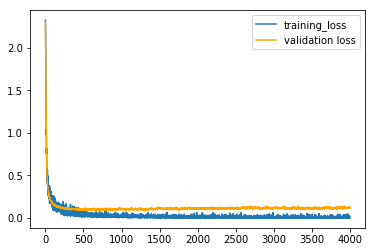

In [60]:
plt.plot(train_losses,label='training_loss')
plt.plot(val_losses,label='validation loss',color='orange')

plt.legend(loc="upper right")
plt.show()
plt.clf()
#it's overtraning a little in the end

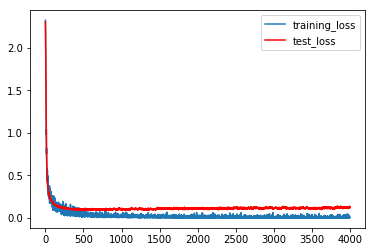

Accuracy on test data set is : 0.9784


In [61]:
plt.plot(train_losses,label='training_loss')
plt.plot(test_losses,label='test_loss',color='red')
plt.legend(loc="upper right")
plt.show()
plt.clf()
print('Accuracy on test data set is :',t_acc) 